### 🟦 **Data Loading and Initial Preparation**

In this step, we load the two primary datasets used for AQI prediction:

* **EPA pollutant measurements** (PM2.5, O₃, CO, NO₂, SO₂, and their computed AQI values)
* **Open-Meteo historical weather dataset** (temperature, wind speed, precipitation, etc.)

We then:

1. **Read both CSV files** containing pollutant and weather data
2. **Convert the date fields to `datetime` objects** to ensure proper alignment
3. **Perform an inner merge** on the shared `date` column to combine pollutant and weather observations for the same day
4. Print dataset dimensions, date coverage, and preview the merged table

This merged dataset is the foundation for all subsequent feature engineering and model training.

---


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load your data
pollutants = pd.read_csv('./../data/boston_pollutants_with_aqi_include_2024.csv')
weather = pd.read_csv('./../data/boston-weather-data(open_meteo).csv', skiprows=3)

# Convert dates
pollutants['date'] = pd.to_datetime(pollutants['date'])
weather['date'] = pd.to_datetime(weather['time'])

# Merge the datasets
df = pd.merge(pollutants, weather, on='date', how='inner')

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (5844, 22)
Date range: 2009-01-01 00:00:00 to 2024-12-31 00:00:00

First few rows:


,date_local,PM2.5,O3,CO,NO2,SO2,date,AQI_PM2.5,AQI_O3,AQI_CO,...,AQI,AQI_Category,num_pollutants_available,time,temperature_2m_mean (°C),precipitation_sum (mm),apparent_temperature_mean (°C),wind_gusts_10m_max (km/h),wind_speed_10m_max (km/h),wind_direction_10m_dominant (°)
0,2009-01-01,6.5,0.021375,0.186957,13.000000,0.333333,2009-01-01,27.0,20.0,2.0,...,27.0,Good,5,2009-01-01,-13.2,0.0,-21.2,63.7,32.8,306
1,2009-01-02,15.0,0.008792,0.483333,31.363636,4.571429,2009-01-02,57.0,8.0,5.0,...,57.0,Moderate,5,2009-01-02,-7.2,0.0,-12.5,42.8,21.5,253
2,2009-01-03,13.9,0.022235,0.320833,15.458333,3.787500,2009-01-03,55.0,21.0,4.0,...,55.0,Moderate,5,2009-01-03,-3.9,0.0,-10.3,52.2,26.9,281
3,2009-01-04,7.9,0.014833,0.315739,20.208333,3.342857,2009-01-04,33.0,14.0,4.0,...,33.0,Good,5,2009-01-04,-4.8,0.0,-10.7,46.1,25.9,303
4,2009-01-05,12.7,0.011500,0.466667,30.090909,3.114286,2009-01-05,52.0,11.0,5.0,...,52.0,Moderate,5,2009-01-05,0.0,0.4,-4.6,29.5,18.0,252


### 🟦 **Train–Validation–Test Split (Chronological)**

To ensure a realistic forecasting setup, the dataset is split **strictly by time** rather than randomly. This mimics real-world AQI prediction, where the model only has access to **past** data when predicting future air quality.

#### **Steps Performed:**

1. **Inspect dataset timespan**

   * Print the earliest and latest dates
   * Compute total number of days and years covered

2. **Define chronological split windows**

   * **Last 1 year → Test set**
   * **Previous 1 year → Validation set**
   * **All earlier data → Training set**

3. **Create the actual splits**
   Using date filters, we generate three non-overlapping subsets:

   * `train_df`
   * `val_df`
   * `test_df`

4. **Print dataset sizes**
   Summary of how many daily observations fall into each split.

5. **Verify no data leakage**
   Assertions check that:

   * Training ends *before* validation begins
   * Validation ends *before* test begins

This ensures the model never sees future information during training—an essential requirement for time-series prediction.

---


In [6]:
from datetime import datetime

# Load and prepare your data (assuming you have df already merged)
# df = merged dataframe with AQI + weather

# First, let's see what date range we have
print("="*60)
print("DATASET DATE RANGE")
print("="*60)
print(f"Earliest date: {df['date'].min()}")
print(f"Latest date: {df['date'].max()}")
print(f"Total days: {len(df)}")
print(f"Total years: {(df['date'].max() - df['date'].min()).days / 365.25:.1f}")

# Determine the split dates
latest_date = df['date'].max()
test_start = latest_date - pd.DateOffset(years=1)  # Last 1 year for testing
val_start = test_start - pd.DateOffset(years=1)    # Previous 1 year for validation

print("\n" + "="*60)
print("SPLIT STRATEGY")
print("="*60)
print(f"Training set:   {df['date'].min()} to {val_start - pd.DateOffset(days=1)}")
print(f"Validation set: {val_start} to {test_start - pd.DateOffset(days=1)}")
print(f"Test set:       {test_start} to {latest_date}")

# Create the splits
train_df = df[df['date'] < val_start].copy()
val_df = df[(df['date'] >= val_start) & (df['date'] < test_start)].copy()
test_df = df[df['date'] >= test_start].copy()

print("\n" + "="*60)
print("SPLIT SIZES")
print("="*60)
print(f"Training:   {len(train_df):4d} days ({100*len(train_df)/len(df):.1f}%)")
print(f"Validation: {len(val_df):4d} days ({100*len(val_df)/len(df):.1f}%)")
print(f"Test:       {len(test_df):4d} days ({100*len(test_df)/len(df):.1f}%)")
print(f"Total:      {len(df):4d} days")

# Verify no data leakage
assert train_df['date'].max() < val_df['date'].min(), "Data leakage: train overlaps with val!"
assert val_df['date'].max() < test_df['date'].min(), "Data leakage: val overlaps with test!"
print("\n✓ No data leakage detected - splits are chronological!")

DATASET DATE RANGE
Earliest date: 2009-01-01 00:00:00
Latest date: 2024-12-31 00:00:00
Total days: 5844
Total years: 16.0

SPLIT STRATEGY
Training set:   2009-01-01 00:00:00 to 2022-12-30 00:00:00
Validation set: 2022-12-31 00:00:00 to 2023-12-30 00:00:00
Test set:       2023-12-31 00:00:00 to 2024-12-31 00:00:00

SPLIT SIZES
Training:   5112 days (87.5%)
Validation:  365 days (6.2%)
Test:        367 days (6.3%)
Total:      5844 days

✓ No data leakage detected - splits are chronological!


### 🟦 **Feature Engineering: Leakage-Free Predictive Inputs**

This section constructs a comprehensive set of **time-series features** for AQI prediction.
All features are explicitly designed to prevent **data leakage**, meaning the model only learns from **past information** when predicting future AQI.

#### **1. AQI-Based Features**

AQI is highly autocorrelated, so we incorporate its historical behavior without relying on same-day values:

* **Lagged AQI** (lags 2 and 3)
* **Short/medium-term trends** via rolling averages (3-day, 7-day)
* **Short and long-term momentum** via AQI differences (1-day and 7-day deltas)

These capture persistence and seasonality in air quality while avoiding overly dominant single-day lag values.

---

#### **2. Pollutant Features (PM2.5, O₃, CO, NO₂, SO₂)**

For each pollutant we compute:

* **Lagged values**: 1, 3, and 7 days
* **Rolling averages**: 3-day and 7-day windows

This provides smoothed pollution history and exposure trends, which are strong predictors of AQI.

---

#### **3. Weather Features**

Weather strongly influences how pollutants disperse.
We include:

* **Lagged temperature, wind speed, and rainfall**
* **3-day and 7-day rolling windows**

These capture persistent meteorological patterns that affect pollutant accumulation.

---

#### **4. Interaction Features**

To model physical relationships between pollution and weather, we add:

* **PM2.5 × wind_speed** (dispersion effect)
* **O₃ × temperature** (ozone formation increases with heat)
* **NO₂ × wind_speed** (traffic emissions + dispersion)

These nonlinear interactions significantly improve predictive power.

---

#### **5. Temporal Features**

We encode calendar patterns that naturally influence AQI:

* **Month and day-of-year**
* **Cyclical encodings** for seasonal smoothness (sine/cosine)
* **Day of week** and weekend indicator
* **Weekly cycles** encoded using sine/cosine

These capture human activity cycles (traffic, heating usage, etc.) and environmental seasonality.

---


In [7]:
# ---------- Feature Engineering ----------
def build_features_generalized(df):
    """
    Leakage-free, reduced AQI-lag dominance.
    - Use AQI rolling averages instead of single-day lag1
    - Include pollutant lags and rolling stats
    - Include weather lags and rolling stats
    - Temporal cyclical features
    """
    df = df.sort_values("date").copy()
    
    # --- AQI features ---
    df['AQI_lag_2'] = df['AQI'].shift(2)
    df['AQI_lag_3'] = df['AQI'].shift(3)
    df['AQI_roll3'] = df['AQI'].shift(1).rolling(3).mean()
    df['AQI_roll7'] = df['AQI'].shift(1).rolling(7).mean()
    df['AQI_diff_1'] = df['AQI'].shift(1) - df['AQI'].shift(2)
    df['AQI_diff_7'] = df['AQI'].shift(1) - df['AQI'].shift(7)
    
    # --- Pollutant features (lag & rolling) ---
    pollutants = ["PM2.5", "O3", "CO", "NO2", "SO2"]
    for p in pollutants:
        if p in df.columns:
            df[f'{p}_lag1'] = df[p].shift(1)
            df[f'{p}_lag3'] = df[p].shift(3)
            df[f"{p}_lag7"] = df[p].shift(7)
            df[f'{p}_roll3'] = df[p].shift(1).rolling(3).mean()
            df[f'{p}_roll7'] = df[p].shift(1).rolling(7).mean()
    
    # --- Weather features (lag & rolling) ---
    weather_cols = {
        "temperature_2m_mean (°C)": "temp",
        "wind_speed_10m_max (km/h)": "wind",
        "precipitation_sum (mm)": "rain"
    }
    for old, base in weather_cols.items():
        if old in df.columns:
            df[f"{base}_lag1"] = df[old].shift(1)
            df[f"{base}_roll3"] = df[old].shift(1).rolling(3).mean()
            df[f"{base}_roll7"] = df[old].shift(1).rolling(7).mean()


    df["PM25_wind"] = df["PM2.5_lag1"] * df["wind_lag1"]
    df["O3_temp"] = df["O3_lag1"] * df["temp_lag1"]
    df["NO2_wind"] = df["NO2_lag1"] * df["wind_lag1"]

    
    # --- Temporal features ---
    df["month"] = df["date"].dt.month
    df["dayofyear"] = df["date"].dt.dayofyear
    df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
    df["month_cos"] = np.cos(2*np.pi*df["month"]/12)
    df["doy_sin"] = np.sin(2*np.pi*df["dayofyear"]/365)
    df["doy_cos"] = np.cos(2*np.pi*df["dayofyear"]/365)
    df["dayofweek"] = df["date"].dt.dayofweek
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
    df["dow_sin"] = np.sin(2*np.pi*df["dayofweek"]/7)
    df["dow_cos"] = np.cos(2*np.pi*df["dayofweek"]/7)

    
    return df.dropna()


train_feat = build_features_generalized(train_df)
val_feat   = build_features_generalized(val_df)
test_feat  = build_features_generalized(test_df)


print(train_feat.shape, val_feat.shape, test_feat.shape)

exclude = [
    "date", "time", "date_local",

    "num_pollutants_available",
    
    # raw AQI outputs
    "AQI", "AQI_Category", 
    "AQI_PM2.5", "AQI_O3", "AQI_CO", "AQI_NO2", "AQI_SO2",

    # raw pollutant inputs (to avoid leakage)
    "PM2.5", "O3", "CO", "NO2", "SO2",

    # raw weather inputs (we only want lag versions)
    "temperature_2m_mean (°C)",
    "precipitation_sum (mm)",
    "wind_speed_10m_max (km/h)",
    "wind_gusts_10m_max (km/h)",
    "apparent_temperature_mean (°C)",
    "wind_direction_10m_dominant (°)",

    # any leftover raw columns
]

feature_cols = [c for c in train_feat.columns if c not in exclude]

print("Number of features:", len(feature_cols))
feature_cols

X_train = train_feat[feature_cols]
y_train = train_feat["AQI"]

X_val = val_feat[feature_cols]
y_val = val_feat["AQI"]

X_test = test_feat[feature_cols]
y_test = test_feat["AQI"]

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)


X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

print(X_train_full.shape, y_train_full.shape)




(4501, 75) (308, 75) (312, 75)
Number of features: 53
(4501, 53) (308, 53) (312, 53)
(4501,) (308,) (312,)
(4809, 53) (4809,)


### 🟦 Baseline Linear Models (Ridge & Lasso)

Train simple linear baselines using standardized features.
Ridge and Lasso provide a reference point to compare against the more complex tree-based models.

We evaluate their **R² scores on the test set** to measure how much variance they explain.

---


In [27]:
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso

ridge = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
lasso = make_pipeline(StandardScaler(), Lasso(alpha=0.01, max_iter=5000))

ridge.fit(X_train_full, y_train_full)
lasso.fit(X_train_full, y_train_full)

print("Ridge R²:", r2_score(y_test, ridge.predict(X_test)))
print("Lasso R²:", r2_score(y_test, lasso.predict(X_test)))

Ridge R²: 0.3000224013406183
Lasso R²: 0.30486283355717025


### 🟦 Final XGBoost Training (Best Hyperparameters)

This cell trains the **final XGBoost model** using the best hyperparameters found during tuning.
We retrain on the **full training data (train + val)** to give the model maximum historical information before evaluating on the test set.

**Key parameters used:**

* `n_estimators = 800`
* `max_depth = 4`
* `learning_rate = 0.03`
* `subsample = 1.0`
* `colsample_bytree = 0.7`
* `reg_lambda = 5.0`

---


In [9]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

final_xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    n_estimators=800,
    max_depth=4,
    learning_rate=0.03,
    subsample=1.0,
    colsample_bytree=0.7,
    reg_lambda=5.0
)

final_xgb.fit(X_train_full, y_train_full)

test_pred_final = final_xgb.predict(X_test)

mae = mean_absolute_error(y_test, test_pred_final)
mse = mean_squared_error(y_test, test_pred_final)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, test_pred_final)

print("\n==== FINAL TEST RESULTS ====")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")



==== FINAL TEST RESULTS ====
MAE:  6.566
RMSE: 8.582
R²:   0.380


### 🟦 Final LightGBM Training (Best Hyperparameters)

Train the optimized LightGBM model using the full training dataset.
The hyperparameters below were selected based on the best validation performance.

**Best params used:**

* `num_leaves = 31`
* `learning_rate = 0.01`
* `n_estimators = 900`
* `subsample = 0.7`
* `colsample_bytree = 1.0`

---


In [10]:
from lightgbm import LGBMRegressor

final_lgbm = LGBMRegressor(
    num_leaves=31,
    learning_rate=0.01,
    n_estimators=900,
    subsample=0.7,
    colsample_bytree=1.0,
    objective="regression",
    random_state=42,
    n_jobs=-1
)

final_lgbm.fit(X_train_full, y_train_full)

test_pred_lgbm = final_lgbm.predict(X_test)

mae = mean_absolute_error(y_test, test_pred_lgbm)
rmse = np.sqrt(mean_squared_error(y_test, test_pred_lgbm))
r2 = r2_score(y_test, test_pred_lgbm)

print("\n==== FINAL LGBM TEST RESULTS ====")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10972
[LightGBM] [Info] Number of data points in the train set: 4809, number of used features: 53
[LightGBM] [Info] Start training from score 35.610314

==== FINAL LGBM TEST RESULTS ====
MAE:  6.526
RMSE: 8.522
R²:   0.389


### 🟦 Final Random Forest Training

Train the tuned Random Forest model on the full training dataset using the best-performing hyperparameters:

* `n_estimators = 600`
* `max_depth = 10`
* `min_samples_split = 2`

---


In [11]:
from sklearn.ensemble import RandomForestRegressor

final_rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=10,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

final_rf.fit(X_train_full, y_train_full)

test_pred_rf = final_rf.predict(X_test)

mae = mean_absolute_error(y_test, test_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, test_pred_rf))
r2 = r2_score(y_test, test_pred_rf)

print("\n==== FINAL RANDOM FOREST TEST RESULTS ====")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")



==== FINAL RANDOM FOREST TEST RESULTS ====
MAE:  6.606
RMSE: 8.509
R²:   0.391


### 🟦 Simple Ensemble (XGB + LGBM + RF)

Combine the three final models by averaging their predictions.
This simple ensemble often improves stability and reduces individual model biases.

The final **MAE, RMSE, and R²** on the test set are computed to evaluate ensemble performance.

---


In [12]:
ens_pred = (test_pred_final + test_pred_lgbm + test_pred_rf) / 3

mae_ens = mean_absolute_error(y_test, ens_pred)
rmse_ens = np.sqrt(mean_squared_error(y_test, ens_pred))
r2_ens = r2_score(y_test, ens_pred)

print("\n==== SIMPLE ENSEMBLE (XGB + LGBM + RF) TEST RESULTS ====")
print(f"MAE:  {mae_ens:.3f}")
print(f"RMSE: {rmse_ens:.3f}")
print(f"R²:   {r2_ens:.3f}")


# Train ensemble predictions
train_pred = (
    final_xgb.predict(X_train_full) +
    final_lgbm.predict(X_train_full) +
    final_rf.predict(X_train_full)
) / 3


train_mae = mean_absolute_error(y_train_full, train_pred)
train_rmse = mean_squared_error(y_train_full, train_pred) ** 0.5
train_r2 = r2_score(y_train_full, train_pred)

print("==== ENSEMBLE TRAIN RESULTS ====")
print(f"MAE:  {train_mae:.3f}")
print(f"RMSE: {train_rmse:.3f}")
print(f"R²:   {train_r2:.3f}")


final_pred = ens_pred    # your ensemble predictions




==== SIMPLE ENSEMBLE (XGB + LGBM + RF) TEST RESULTS ====
MAE:  6.504
RMSE: 8.464
R²:   0.397
==== ENSEMBLE TRAIN RESULTS ====
MAE:  5.292
RMSE: 6.704
R²:   0.727


In [22]:
def aqi_to_class(aqi):
    if aqi <= 50:
        return 0  # Good
    elif aqi <= 100:
        return 1  # Moderate
    elif aqi <= 150:
        return 2  # Unhealthy-Sensitive
    elif aqi <= 200:
        return 3  # Unhealthy
    else:
        return 4  # Very Unhealthy / Hazardous

y_test_cls = y_test.apply(aqi_to_class)
pred_cls = pd.Series(final_pred).apply(aqi_to_class)

from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("\n=== Classification Metrics (converted from regression) ===")
print(classification_report(y_test_cls, pred_cls, digits=3))

print("Macro F1:", f1_score(y_test_cls, pred_cls, average="macro"))
print("Weighted F1:", f1_score(y_test_cls, pred_cls, average="weighted"))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_cls, pred_cls))



=== Classification Metrics (converted from regression) ===
              precision    recall  f1-score   support

           0      0.938     1.000     0.968       289
           1      1.000     0.174     0.296        23

    accuracy                          0.939       312
   macro avg      0.969     0.587     0.632       312
weighted avg      0.943     0.939     0.919       312

Macro F1: 0.6322352503257026
Weighted F1: 0.9186447431841068

Confusion Matrix:
[[289   0]
 [ 19   4]]


### 🟦 Actual vs. Predicted AQI (Scatter Plot)

Visualize ensemble performance by plotting predicted AQI values against the actual test values.
The red dashed line represents a perfect prediction (`y = x`), helping assess bias and variance in model predictions.

---


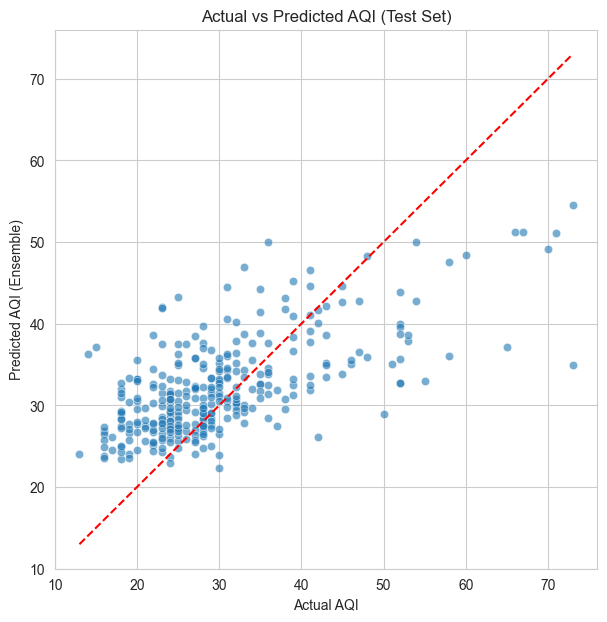

In [13]:
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=final_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI (Ensemble)")
plt.title("Actual vs Predicted AQI (Test Set)")
plt.grid(True)
plt.show()


### 🟦 AQI Prediction Over Time (Test Set)

Plot the actual and ensemble-predicted AQI values across the test period.
This time-series view highlights how well the model tracks daily AQI trends and where prediction errors occur.

---


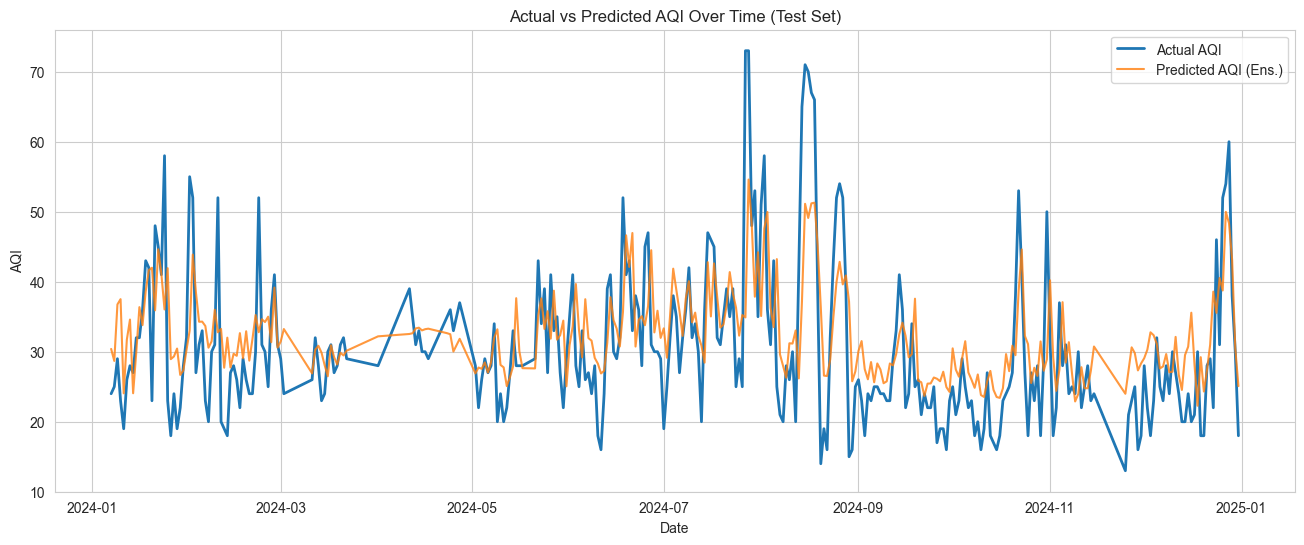

In [14]:
plt.figure(figsize=(16, 6))
plt.plot(test_feat['date'], y_test, label="Actual AQI", linewidth=2)
plt.plot(test_feat['date'], final_pred, label="Predicted AQI (Ens.)", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("AQI")
plt.title("Actual vs Predicted AQI Over Time (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


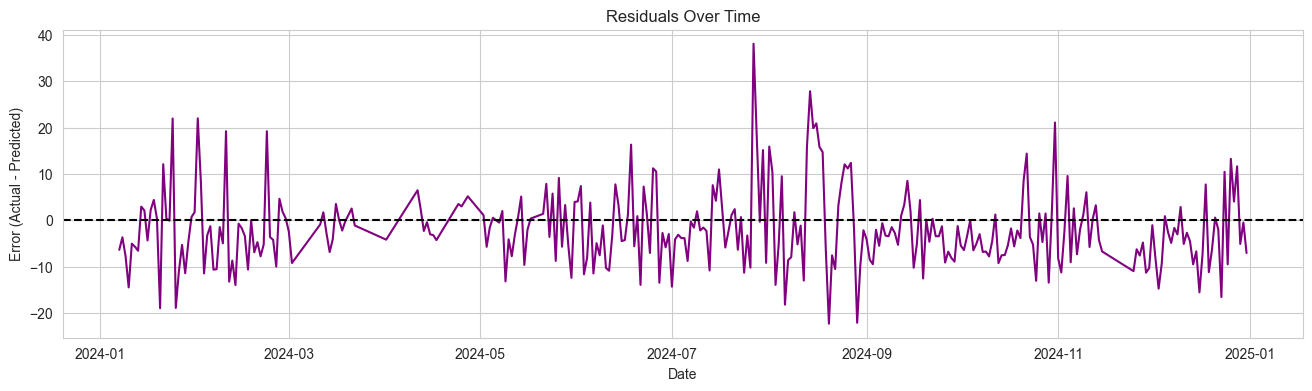

In [15]:
residuals = y_test - final_pred

plt.figure(figsize=(16, 4))
plt.plot(test_feat['date'], residuals, label="Residuals", color="purple")
plt.axhline(0, linestyle="--", color="black")
plt.xlabel("Date")
plt.ylabel("Error (Actual - Predicted)")
plt.title("Residuals Over Time")
plt.grid(True)
plt.show()


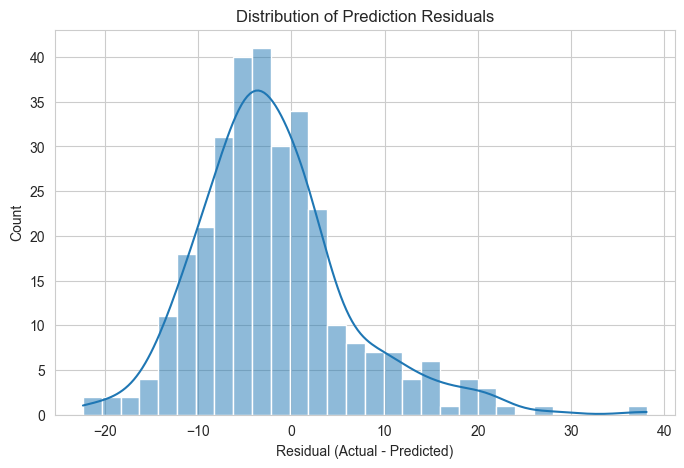

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Distribution of Prediction Residuals")
plt.grid(True)
plt.show()


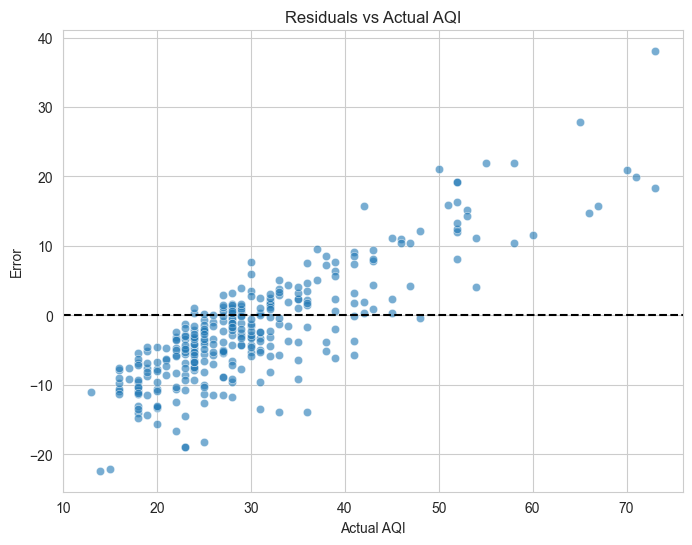

In [17]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(0, linestyle="--", color="black")
plt.xlabel("Actual AQI")
plt.ylabel("Error")
plt.title("Residuals vs Actual AQI")
plt.grid(True)
plt.show()


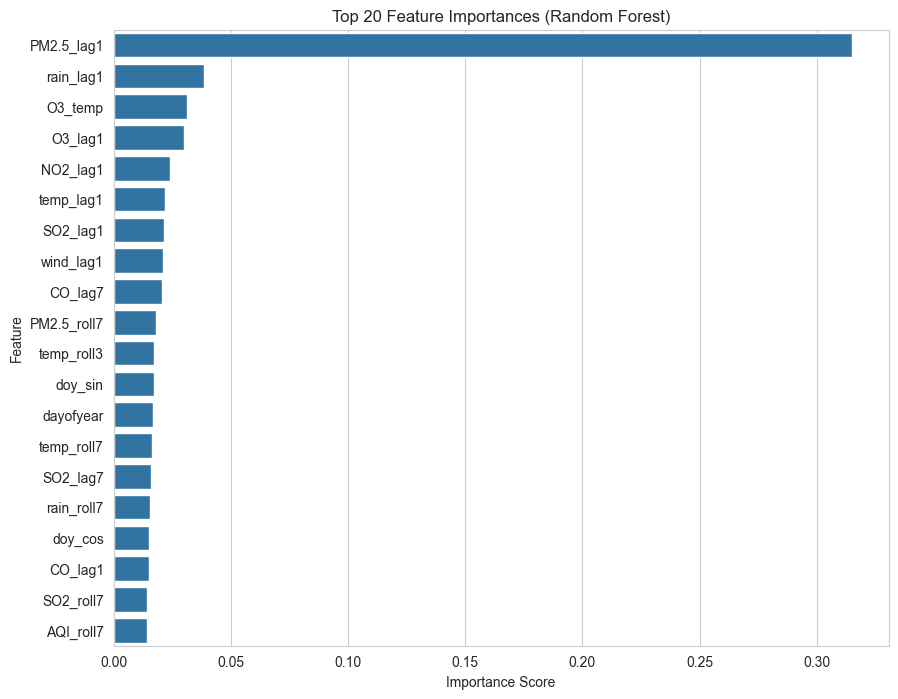

In [18]:
importances = final_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feat_names_sorted = np.array(feature_cols)[indices]

plt.figure(figsize=(10, 8))
sns.barplot(x=importances[indices][:20], y=feat_names_sorted[:20])
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


In [19]:
import pickle

final_models = {
    "xgb": final_xgb,
    "lgbm": final_lgbm,
    "rf": final_rf
}

with open("aqi_ensemble_models.pkl", "wb") as f:
    pickle.dump(final_models, f)

print("Saved: aqi_ensemble_models.pkl")


Saved: aqi_ensemble_models.pkl
